In this notebook, we repeat the 3 rings experiment in Kale flow code. The code in the Kale gradient descent section is taken directly from theirs. Here we use $L-BFGS$ method for the optimization of KKL.

In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import scipy.optimize as sco 
import os
import ot
import pickle

import logging 
import pandas as pd
import torch

In [58]:
def _generate_data():
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

# Kale flow

In [4]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.gradient_flow import gradient_flow
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kernels import gaussian_kernel
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.config import LOG_LEVELS

In [85]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation
def _gen():
    return X, Y

_gf_default_kwargs = dict(
    max_iter=50000,
    random_seed=20,
    noise_level_callback=lambda x: 1e-10,
    num_noisy_averages=1,
    generator=_gen,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.1},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs = {
    "inner_max_iter": 800,
    "inner_tol": 1e-6,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 1e-2,
    "optimization_method":"newton",
}

In [8]:
results = {}

In [9]:
import time 
import numpy as np
import torch

for _lambda_, lr, exp_name in zip([0.001, 10000], [0.0001, 0.001], ['kale_0001', 'kale_10000']):
    t0 = time.time()
    X,Y = _generate_data()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(lr=lr, loss_kwargs={**_kale_default_kwargs, 'lambda_': _lambda_}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = { 
        'args': args,
        'X': X,
        'Y': Y,
        'trajectories': trajectories,
        'records': records,
        'loss_states': loss_states
    }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: X.requires_grad: False, Y.requires_grad: True


total time 622.384s
total time 590.429s


In [10]:
name = 'kale_3rings.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_0001"]['trajectories'])

name = 'mmd_3rings.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_10000"]['trajectories'])

kale_3rings.npy
mmd_3rings.npy


# KKL flow

In [1]:
import kkl.divergences as dv
import kkl.kernels as kl
import kkl.generate_data as gy 


C:\Users\cleme\AppData\Local\Temp\ipykernel_27452\4129650004.py:35: OptimizeWarning: Unknown solver options: xtol
  result = sco.minimize(J1,x0,jac = dJ1,method='L-BFGS-B',options= options, callback = callback)


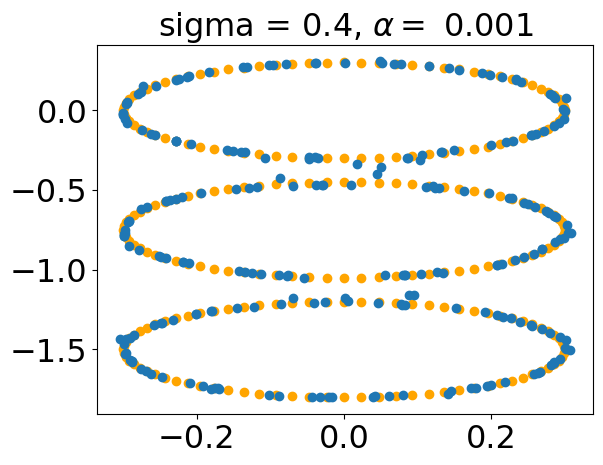

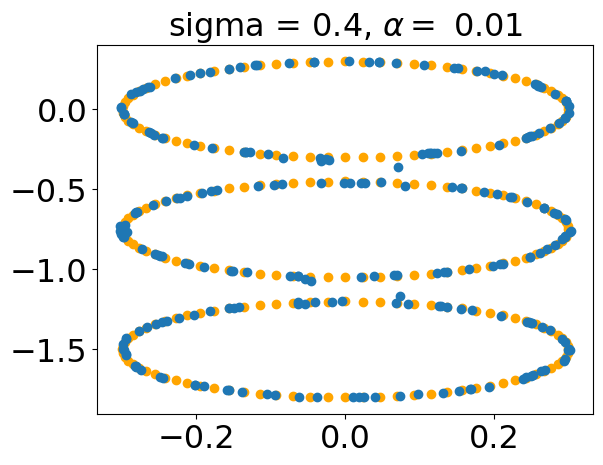

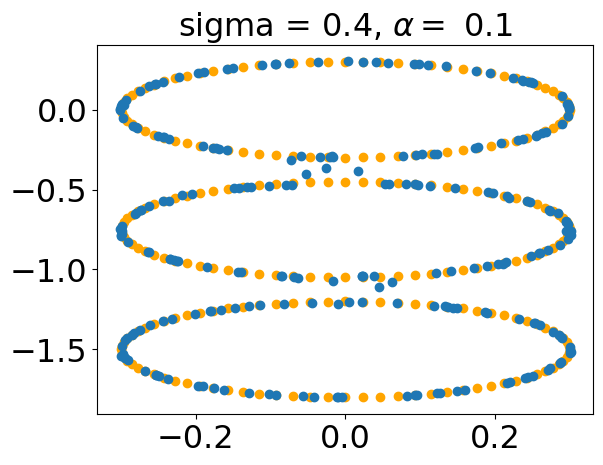

In [61]:
y,x = _generate_data()
x = x.detach().numpy()
y = y.detach().numpy()

n = len(x)
m = len(y)
T = 100 # nombre d'itérations
eps = 0.0001
Alpha = [0.001,0.01,0.1]
sigma = 0.4
k = lambda x,y :  kl.k_gauss(x,y,sigma)
dk = lambda x,y : kl.dk_gauss(x, y,sigma)

Ky = 1/m * k(y,y) 

for alpha in Alpha:
    X= []
    l_J = []
    
    def callback(x):
        X.append(np.array([x[:n],x[n:]]).T)
        l_J.append(J1(x))
        ED.append(dv.energy_distance(np.array([x[:n],x[n:]]).T,y))
        
    options = {'maxiter': 100,'gtol': -1,'xtol': -1,'ftol':0 }
        
        
    J1 = lambda x : dv.KKL(np.array([x[:n],x[n:]]).T, y, k,Ky,alpha) 
    dJ1 = lambda x : np.hstack(dv.WGrad_KKL(np.array([x[:n],x[n:]]).T, y, k,dk,Ky,alpha, sigma).T)
    x0 = np.hstack(x.T)
    
    result = sco.minimize(J1,x0,jac = dJ1,method='L-BFGS-B',options= options, callback = callback)
    
    x_fin = np.array([result.x[:n],result.x[n:]]).T
    X = np.asarray(X)
    
    name_X = 'kkl_3rings_lbfgs_alpha_'+str(alpha)+'_particles.npy'
    np.save('save_data/3_rings/'+name_X, X)


    plt.figure()  
    plt.scatter(y[:,0],y[:,1],color = "orange")  
    plt.scatter(X[-1,:,0], X[-1,:,1])
    plt.title("sigma = " + str(sigma) + r", $\alpha =$ " + str(alpha))


In [62]:
X_0_001 = np.load('save_data/3_rings/kkl_3rings_lbfgs_alpha_'+str(0.001)+'_particles.npy')

X_0_01 = np.load('save_data/3_rings/kkl_3rings_lbfgs_alpha_'+str(0.01)+'_particles.npy')

X_0_1 = np.load('save_data/3_rings/kkl_3rings_lbfgs_alpha_'+str(0.1)+'_particles.npy')


We take $\alpha = 0.01$ for the comparison with other methods.

 # PLOTS

In [66]:
plt.rcParams['xtick.labelsize'] = 23  # X-tick labels font size
plt.rcParams['ytick.labelsize'] = 23  # Y-tick labels font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
plt.rcParams['axes.labelsize'] = 20   # X and Y axis labels font size
plt.rcParams['axes.titlesize'] = 23  # Title font size

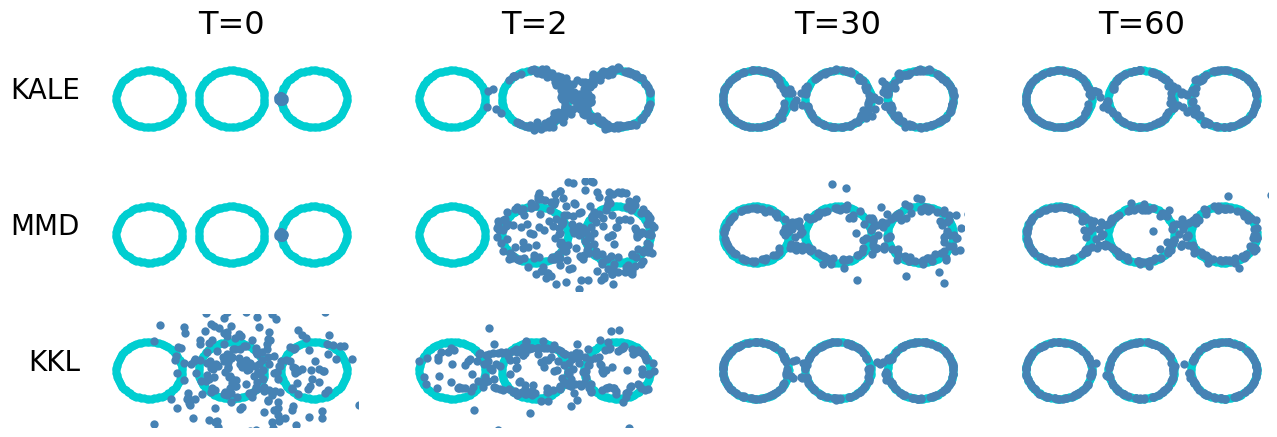

In [90]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 30, 60]

axs[0,0].text(-0.1, 0.5, "KALE", size=20, transform=axs[0,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[0]):
    ax.set_title(f'T={it}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(results["kale_0001"]['X'][:, 1], results["kale_0001"]['X'][:, 0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(results["kale_0001"]['trajectories'][it, :, 1], results["kale_0001"]['trajectories'][it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[1,0].text(-0.1, 0.5, "MMD", size=20, transform=axs[1,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[1]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(results["kale_10000"]['X'][:, 1], results["kale_10000"]['X'][:, 0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(results["kale_10000"]['trajectories'][it, :, 1], results["kale_10000"]['trajectories'][it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[2,0].text(-0.1, 0.5, "KKL", size=20, transform=axs[2,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[2]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    if it < 63:
        ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
        ax.scatter(X_0_01[it][:,1],X_0_01[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    

    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, '3rings_lbfgs_alpha_0_01.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300,bbox_inches='tight')

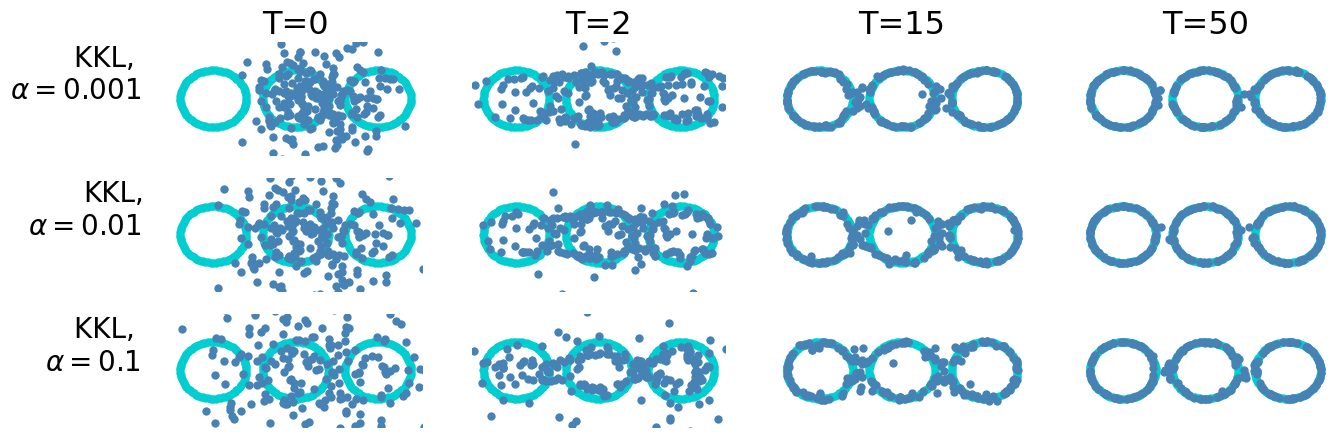

In [70]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 15, 50]

axs[0,0].text(-0.1, 0.5, "KKL, \n" +  r"$\alpha = 0.001$ ", size=20, transform=axs[0,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[0]):
    ax.set_title(f'T={it}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(X_0_001[it][:,1],X_0_001[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[1,0].text(-0.1, 0.5, "KKL,\n" +  r"$\alpha = 0.01$ ", size=20, transform=axs[1,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[1]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(X_0_01[it][:,1],X_0_01[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[2,0].text(-0.1, 0.5, "KKL, \n" +  r"$\alpha = 0.1$ ", size=20, transform=axs[2,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[2]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    ax.scatter(X_0_01[it][:,1],X_0_01[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')

    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'lbfgs_comparaison_alpha.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300,bbox_inches='tight')

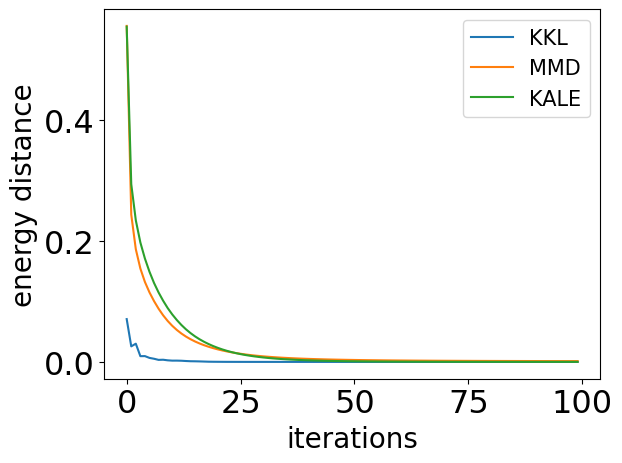

In [81]:
ED_mmd = []
ED_kale = []
ED_kkl = []
for t in range(T):
    if t < 63:
        x_t = X_0_01[t]
    ED_kkl.append(dv.energy_distance(x_t,y))
    ED_mmd.append(dv.energy_distance(results["kale_10000"]['trajectories'][t],results["kale_10000"]['X']))
    ED_kale.append(dv.energy_distance(results["kale_0001"]['trajectories'][t],results["kale_0001"]['X']))
    
plt.figure()
plt.plot(ED_kkl,label = "KKL" ) 
plt.plot(ED_mmd,label = "MMD" )
plt.plot(ED_kale, label = "KALE")
plt.xlabel("iterations")
plt.ylabel("energy distance")
plt.legend()

output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'lbfgs_energy_distance_comp.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
plt.savefig(output_path,dpi = 200,bbox_inches='tight')

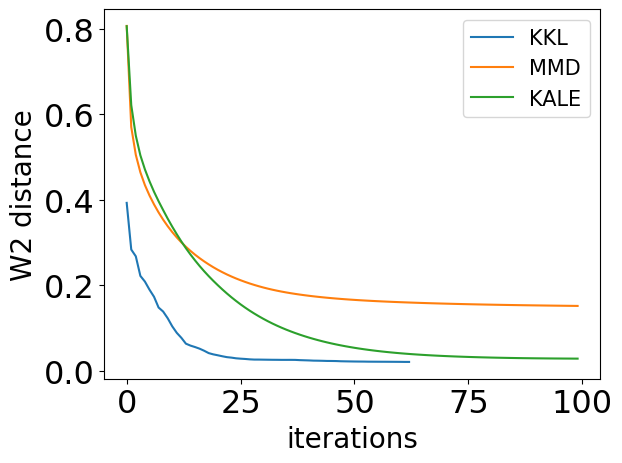

In [83]:
Wass2_mmd = []
Wass2_kale = []
Wass2_kkl = []
for t in range(T):
    if t < 63:
        x_t = X_0_01[t]
        a = np.ones((len(x_t),)) / len(x_t)
        b = np.ones((len(y),)) / len(y)
        M = ot.dist(x_t,y)
        Wass2_kkl.append(np.sqrt(ot.emd2(a, b, M)))
    
    if t<100:
        a = np.ones((len(results["kale_10000"]['trajectories'][t]),)) / len(results["kale_10000"]['trajectories'][t])
        b = np.ones((len(results["kale_10000"]['X']),)) / len(results["kale_10000"]['X'])
        M = ot.dist(results["kale_10000"]['trajectories'][t],results["kale_10000"]['X'])
        Wass2_mmd.append(np.sqrt(ot.emd2(a, b, M)))

        a = np.ones((len(results["kale_0001"]['trajectories'][t]),)) / len(results["kale_0001"]['trajectories'][t])
        b = np.ones((len(results["kale_0001"]['X']),)) / len(results["kale_0001"]['X'])
        M = ot.dist(results["kale_0001"]['trajectories'][t],results["kale_0001"]['X'])
        Wass2_kale.append(np.sqrt(ot.emd2(a, b, M)))
    
    
plt.figure()
plt.plot(Wass2_kkl,label = "KKL" ) 
plt.plot(Wass2_mmd,label = "MMD" )
plt.plot(Wass2_kale, label = "KALE")
plt.xlabel("iterations")
plt.ylabel("W2 distance")
plt.legend()

output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'lbfgs_wass_distance_comp.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
plt.savefig(output_path,dpi = 200,bbox_inches='tight')

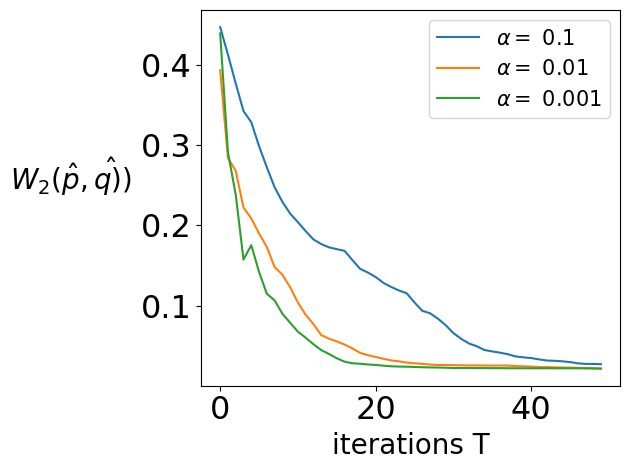

In [94]:
W2 = np.zeros(((3,50)))
for t in range(50):
    b = np.ones((len(y),)) / len(y)
    
    a = np.ones((len(X_0_1[t]),)) / len(X_0_1[t])
    M = ot.dist(X_0_1[t],y)
    W2[0,t] = np.sqrt(ot.emd2(a, b, M))
    
    a = np.ones((len(X_0_01[t]),)) / len(X_0_01[t])
    M = ot.dist(X_0_01[t],y)
    W2[1,t] = np.sqrt(ot.emd2(a, b, M))
    
    a = np.ones((len(X_0_001[t]),)) / len(X_0_001[t])
    M = ot.dist(X_0_001[t],y)
    W2[2,t] = np.sqrt(ot.emd2(a, b, M))

plt.plot(W2[0],label = r"$\alpha = $ " + str(0.1))
plt.plot(W2[1],label = r"$\alpha = $ " + str(0.01))
plt.plot(W2[2],label = r"$\alpha = $ " + str(0.001))
plt.xlabel("iterations T")
plt.ylabel(r"$W_2(\hat{p},\hat{q)})$",labelpad=50, rotation=0)
plt.legend()
plt.tight_layout()

output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, 'lbfgs_wasserstein_kkl.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 200,bbox_inches='tight')